# Demo - Probabilistic Fourier with AR model on coefficients

This file provides an demo of the probabilistic Fourier framework as outline in "Bayesian spectrum estimation of unevenly sampled data" - Qi et al.

$$ {\bf{s}}_t = {\bf{s}}_{t-1} + {\bf{w}}_t $$
$$ {\bf{y}}_t = C^\top {\bf{s}}_t + {\bf{v}}_t $$

## Load packages and functions

In [1]:
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using FFTW
using LAR
using LAR.Node
using Distributions

include("../functions/auxiliary/buffer.jl")
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
;

## Settings

In [2]:
# data loading
sound_file = "../data/woman.wav"   # specify sound location
fs_desired = 8000                  # specify desired sampling frequency

# input buffer parameters
step_size = 1                      # specify step size of buffer
buffer_size = 30                    # specify size of buffer

# probabilistic fourier parameters 
var_observation = 1e-4               # specify observation noise var
freq_bins = 15
freq = collect(fs_desired/(2*(freq_bins+1)):fs_desired/(2*(freq_bins+1)):(fs_desired/2-fs_desired/(2*(freq_bins+1))))

# AR modelling
AR_order = 2
iterations = 5
;

## Load data

In [3]:
# load and process speech signal
x_time, fs_time = wavread(sound_file, format="native")
fs_time = Int(fs_time)
x_time = x_time[1*fs_time+1:4*fs_time]
x_time = resample(x_time, fs_desired/fs_time)
x_time = 100*x_time/var(x_time)
x_time_clean = x_time
x_time = x_time_clean #+ rand(Distributions.Normal(0, sqrt(var_observation)), length(x_time_clean))

# specify time axis
t = collect((1:length(x_time))/fs_desired)

# create audioplayer
audioplayers(x_time, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQBAB9e99dwSvvOCzr0Y0K69b3FzvS43ALwLE4A9PwrqPS2aMj5i1Wk+OTqBPi5vcz4LIms+nr0SPofdnDzp1/68xy7UvHWp2705qEe+OFsmvn1Ulr2+b0K9u5EqvdpOhboVHD09fGo4PZfZhjygR428jt9TvbVHgr09r6q9xGHvvQanEL462+y9/NKlvUKogr0qtS+97VHvPH8A6z2nDy0+a0BQPq6/ej4dZoE+mVZ4Po8LJj7Vhh49mJHevFk927zBps69SxBNvhQPQb5tV8K93PdJvZUucb1yrs68ZAMhPdtScj2aZBE9V/o9PJe7jrzOwEW9zzyavaBCy720ZAm+ZtIFvoLa0L09q5u9T9MvvS96HT2vDQk+sAJBPn7zYj4TpYY+TJaNPlDAWT7IHZU9FNb8O8hZEbpm2pm9CmlSvmQjYr40YQa+t8iqvWqMyb1nt469zvPMPBSUrT2LmHk9BNKcPKKDTzzImM48Dx+PvBGavr3cYAW+QgbqvT2b0b1XLdK9wKGpvTpBrLutIrk9gUgiPuJjQD5tzGc+rCCJPoBiej6M0QI+iiNXPDReaTvA/ae8CwgWvsZwdb40wze+9pzcvd9B4b128N29QiUTvd/CBD2nH1M9rgsTPaeHVTww2mA7ortsPB63j7wqI7i9aorUvauXT70Jfd+8Q03xvH55Qz2hYzA+6nhpPsFdaT7KQGw+iXodPgstij0WuUA9UY0TvBSXIL7Hmla+E3sUvik//r2/jSC+DXLxvZ0udrxwSEE9uziEPXhcpz1qNIQ96sMqPfDiNz1F2o08PQSkvZe8Dr6xq9G9i5G5vQeLEb66tAW+e2QPvRwSAD2VrzI99k6vPccDFT77MTE+6tkZPlnF+z0vzsU984ODPelYqTwCeOG8tawmvfsbMr1aWqe9bVbrvStAqr3DyGi9vkmPvcRBhr0KA0u8090dPNbah7zXSgu9XqLQvJMyhLxwj4W80YAsvGh7QDzEEYM9CVYBPr8/Lj7yH0k+M4VxPisqVD5Ul4A9OtEtvOo6ujzopSm9teZUviMqXb6iR8W9f9mxvV7aHL5BZra9Fno+PVGxvD3tBYw9iPCwPTYt+z31OfQ9E4ybPd+lXDxzWhi9DE+AvQTjkL05d+C9QrwKvj49170PI0u9Y0AqvUAdGL0/LQu6J9EtPW4rJz33pcY8xK/FPPeazDzyzqo7Q5/ovEA2EL1Gy8a8in2jvEWD4LwGENO8mgaZvLS0Crt35rM7HrrfOgpbo7sOe5E7Gf/8O2iK2bsS7cC89xiYvBVs0ruoFWi8m8cGvHOuPjwCvr481m6zPHGR+jxvWh09Wl8xPfS6Dz3U+r88ZLyAPA62Rzw+xKU6eNW/vAFEB71i1wG9ti0fvUnDWL2fBzm9FC0QvagbEL1FaAu9xoirvI7zZLzvW1O8M/qju4tkkjuTdxw8Ki2hPAh1HT1R7jA9qvc3Pbfsdj3ryI49OXF0PayLPD0K3AI9MMuvPEC6OLvDNfK832FyvQJ8nr0HUae9xUynvTRgvb0fR7S9wB99vYjmOb1wcha93W2kvIXwkbk1PD88fRHGPGOfAj2SwCM9hymCPXbZuj1dEts94cn7PZaLAT6YF9A9Iw13PcnyNT0wD1274IOWvRPi2r2xGdW9EBIBvksvIb4yNQi+rKS1vetRmr0BGIy98IPjvIWSMDySMbI8DUAAPQPgVz3b35E95U2ePbr8vD0oavY9jrsVPujFIT6SK+k9YLcMPW/EpzyOTA89TmUXvQlVB74QmM69mOhBvW6w0b1hnAq+EJ1ovQLrTTtQ1te8YhFWvLH0XT2muJA9EDIYPUGeGj3+3lc9jiCtPBvftLzV+c6843HavPE1X72BCoq9AMlzvZ3eXL2dlEa937wVvdR8przf7A+8VwspvJZvB7yhbxE4qVgtPFAE+zq/mfm7e74YO4EoszucLvu7jI/nuyQnkjtB+Zi7uHhcvO9ZJ7xtJ+O7DWjlu8ncgbtHNgk7KTV5O/VerzsV8M47xxwLPNcnuTw6ask8xCxxPF9zNTyu+Kg8+TmWPDL7IDwa8GY8EDl9PHm/mDuiTo66VoYSut4TsbvDUta79YXhu7jWyrs4Z8+7yIrPu/0blLqB9xq7AktYOgaDkTsavj87fm0EPF3Tcjx+rvQ7UzMUPL88nTwduFI8W2g/O8vRJTznb5g8eVgrPJamoDtwmIg7pSiNul4WuTsRHS88Sa3Xu3nW/7v1GwU8TOrSO7qLyrukUoo69dVPO5hFIzcqgrw78UVyO0NMbrk2MYc7E/QpPMo3rDvOny06Ii0QPLoXlDurnlg8x4/iO1/7NbkfJqQ8JeAjPJIftTs+YIk8fXbxOn7mxbjL0no8bIPqO1ZzTbwTn5y7LMkYupCtLrwZHBO7CvmKOcMtBryvGMk7SKueu3YYpbw65Cg8YQ2kPACnTbzM7dy8SCQDPN79vTwiN6i8cS6HvORYyzyBu2m8yNWzvOqJ1TyE4Bm7ZwQkvRG92DrCDFE8n1PKvKJU5LxgjoK7pm8DvBMEkLyGdLq7fymbvC2IKrx4yGQ893BIvPbDBr1j+yw8ArTaO6Gay7zyVhO8i9dpO6BdA7zCdIe8F/V5u0Lonzq4VJS8sDF5vKluorvly627c+iPvHQxhbyqJb27mvMhvBN8ArztXLa7wPAJu7Y38LpsjDy7x4ZBu/VTVrhxrPo6JlCdu7cPabsLlqG6UGGtuo0JQLv5ld+7SgeFuwYTkbtDqUK6tByqOVNtcrnvad+5FPxtOwpZg7ls1IW7wCYNuw1BobvTbfa7hMz7u7INz7vljve70kw6vNosB7xij667fGLbuhapVLuj1Da50vDNO0RxvTtDUBI7wgJpO0jYoTtQR+c6hVakOj1uqzp2LSq6q8AXOEQYQ7ofW7O6Z7HUuiwl5LqJfF06rEXFubuDjrvehJS7Kw+6u/Ofy7twMM67rOa5u+Qa+LpN6+W4qQFDO0A6Gzoo2wa4azaOO0kppjsV0Zs6MgGNuqrnTjuC+V07vTzruqMAXrp53187Fq5YO/i9mbkV9QW5kTJhO7gnaDuhfaE7Rte7O4JE9zvSAcQ7chLkO8VBtzucwo47tjWtO5gzQDuZH3E6yflmO034YTtcJts7RtG7O5CIfDtQ9pg78xGVOySSejuRC1c7G+apOzHN6zv6t3E7ZVwvO6fksDtv2Iw7ONLDOxUTITwd8gM8j6SuO7VwxTuYXcM7f9qYOhBgbDvnEPs1iYqDuwksrbsIkaK7wV5Vu2mOk7sRyAK6LFYVOz6UBTrZ9Am4Go6YOm479jm1xUu7F2aku2KQ1btoLfi7m8L1u91uKrwYXki8I1lBvPTzL7xD3Vq8lNQtvACRGLzw4zi8Uec8vJfSO7zA+j682IxqvM3EWbxg83O8ekh0vMDobLxNNF28GpRwvNgRY7xNhQS8fb44vHkXM7yVvxi8joMPvESTELyVYVi8rxNcvA4zZ7ytGUG8FcYzvHmGN7ym2TO8wQoovKDSNrxctEu8J+xFvGPzCrzKCBq8q+ExvEG2CbyRoNK7MA72uyCTortPpnu7RLD2u74Q37va/4W76CtYu26rVru8q4K7OPKau/I8N7qPAee64ClzurKOszmECk84NfDuOrUSQDrinhs5L0AVO+6f77rMY2u7ATunOXInZLmB/0s62PwgOfNScjuqBkM7KHANOxfTqTuG/cc78LurOyswHDwXOOM7LgnbOwpWxTsELLA7G6jgO87dkzvbIvY78Je1O3iDhjvJppM7t/r8O09r6jvDArY7CJANPG47DTwXx6I7F8jVOxyXCjzxgiA85pklPOLZGzzF1w48TqEkPNsgRDyzpw48a/raO1LkDzxfA

## Visualize data

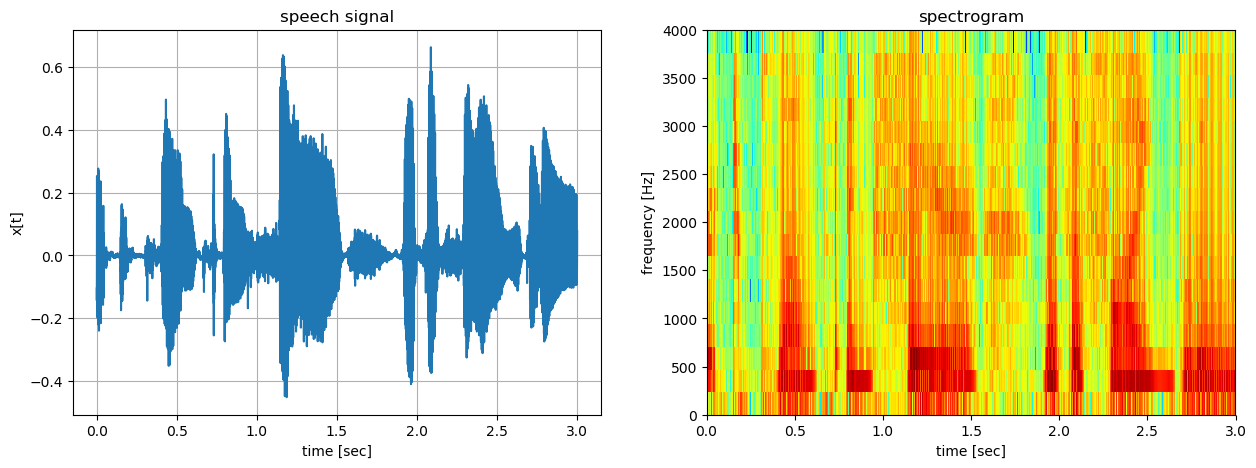

In [4]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_time)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, 32, 0, fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("speech signal"), ax[2].set_title("spectrogram")
;

## Specify generative model

In [5]:
# create factor graph
fg = FactorGraph()

# placeholders
z_min = Array{Variable,1}(undef, 2*length(freq))
γ = Array{Variable,1}(undef, 2*length(freq))
θ = Array{Variable,1}(undef, 2*length(freq))
z = Array{Variable,1}(undef, 2*length(freq))

# specify observation noise
@RV v ~ GaussianMeanVariance(zeros(buffer_size), var_observation*Ic(buffer_size))

# specify previous hidden state (spectral component buffer)
for k = 1:2*length(freq)
    @RV [id=pad(:z_min,k)] z_min[k] ~ GaussianMeanVariance(placeholder(pad(:μ_z_min, k), dims = (AR_order,)),
                                        placeholder(pad(:Σ_z_min, k), dims = (AR_order, AR_order)))
    @RV [id=pad(:γ,k)] γ[k] ~ ForneyLab.Gamma(placeholder(pad(:a_γ,k)), placeholder(pad(:b_γ,k)))
    @RV [id=pad(:θ,k)] θ[k] ~ GaussianMeanVariance(placeholder(pad(:μ_θ,k), dims=(AR_order,)), placeholder(pad(:Σ_θ,k), dims=(AR_order, AR_order)))
    @RV [id=pad(:z,k)] z[k] ~ LAR.Autoregressive(θ[k], z_min[k], γ[k])
end

# specify Fourier matrix
Ceme1 = Array{Variable,1}(undef, 2*length(freq))
for k=1:2*length(freq)
    @RV Ceme1[k] 
    placeholder(Ceme1[k], pad(:Ceme1,k), dims = (buffer_size, AR_order))
end

# specify observations
@RV x = sum(Ceme1.*z)
@RV y = x + v

# create placeholder for observations
placeholder(y, :y, dims = (buffer_size,))

# draw factor graph
ForneyLab.draw(fg)
ForneyLab.draw(fg, external_viewer=:default)
;

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 18235194555177068385 -->
 18235194555177068385 
 
 placeholder_a_γ_17 
 
<!-- 13211782878391849722 -->
 13211782878391849722 
 
 placeholder_μ_z_min_14 
 
<!-- 6181594085283255620 -->
 6181594085283255620 
 
 𝒩 
 gaussianmeanvariance_39 
 
<!-- 2913205573498990011 -->
 2913205573498990011 
 
 placeholder_μ_θ_19 
 
<!-- 6181594085283255620--2913205573498990011 -->
 6181594085283255620--2913205573498990011 
 
 μ_θ_19 
 1 out 
 2 m 
 
<!-- 8559247161849412932 -->
 8559247161849412932 
 
 placeholder_Σ_θ_19 
 
<!-- 6181594085283255620--8559247161849412932 -->
 6181594085283255620--8559247161849412932 
 
 Σ_θ_19 
 1 out 
 3 v 
 
<!-- 10697419317449030374 -->
 10697419317449030374 
 
 placeholder_b_γ_30 
 
<!-- 16775615470887583858 -->
 16775615470887583858 
 
 placeholder_Σ_θ_20 
 
<!-- 18306534488367243562 -->
 18306534488367243562 
 
 𝒩 
 gaussianmeanvariance_27 
 
<!-- 5061706994460288704 -->
 5061706994460288704 
 
 placeholder_μ_θ_13 
 
<!-- 18306534488367243562--5061706994460288704 -->
 18306534488367243562--5061706994460288704 
 
 μ_θ_13 
 1 out 
 2 m 
 
<!-- 10938651034830546830 -->
 10938651034830546830 
 
 placeholder_Σ_θ_13 
 
<!-- 18306534488367243562--10938651034830546830 -->
 18306534488367243562--10938651034830546830 
 
 Σ_θ_13 
 1 out 
 3 v 
 
<!-- 5637954253035252312 -->
 5637954253035252312 
 
 𝒩 
 gaussianmeanvariance_21 
 
<!-- 9975692441469228100 -->
 9975692441469228100 
 
 placeholder_Σ_θ_10 
 
<!-- 5637954253035252312--9975692441469228100 -->
 5637954253035252312--9975692441469228100 
 
 Σ_θ_10 
 1 out 
 3 v 
 
<!-- 9908332272458919997 -->
 9908332272458919997 
 
 placeholder_μ_θ_10 
 
<!-- 5637954253035252312--9908332272458919997 -->
 5637954253035252312--9908332272458919997 
 
 μ_θ_10 
 1 out 
 2 m 
 
<!-- 18266382692136512093 -->
 18266382692136512093 
 
 placeholder_Σ_z_min_26 
 
<!-- 11390600859374186719 -->
 11390600859374186719 
 
 placeholder_μ_z_min_29 
 
<!-- 6438676838795593450 -->
 6438676838795593450 
 
 placeholder_a_γ_19 
 
<!-- 8890278731884818243 -->
 8890278731884818243 
 
 placeholder_Ceme1_28 
 
<!-- 16237578552565097286 -->
 16237578552565097286 
 
 AR 
 autoregressive_11 
 
<!-- 1731020545132182105 -->
 1731020545132182105 
 
 Gam 
 gamma_11 
 
<!-- 16237578552565097286--1731020545132182105 -->
 16237578552565097286--1731020545132182105 
 
 γ_11 
 1 out 
 4 γ 
 
<!-- 14044558165623085418 -->
 14044558165623085418 
 
 𝒩 
 gaussianmeanvariance_23 
 
<!-- 16237578552565097286--14044558165623085418 -->
 16237578552565097286--14044558165623085418 
 
 θ_11 
 1 out 
 3 θ 
 
<!-- 7164446548411065363 -->
 7164446548411065363 
 
 𝒩 
 gaussianmeanvariance_22 
 
<!-- 16237578552565097286--7164446548411065363 -->
 16237578552565097286--7164446548411065363 
 
 z_min_11 
 1 out 
 2 x 
 
<!-- 433649681681308779 -->
 433649681681308779 
 
 placeholder_Σ_θ_07 
 
<!-- 7192996815008163521 -->
 7192996815008163521 
 
 placeholder_Σ_z_min_15 
 
<!-- 14988342072670625343 -->
 14988342072670625343 
 
 placeholder_b_γ_06 
 
<!-- 15282016601560219354 -->
 15282016601560219354 
 
 𝒩 
 gaussianmeanvariance_28 
 
<!-- 15282016601560219354--13211782878391849722 -->
 15282016601560219354--13211782878391849722 
 
 μ_z_min_14 
 1 out 
 2 m 
 
<!-- 12092943508568309665 -->
 12092943508568309665 
 
 placeholder_Σ_z_min_14 
 
<!-- 15282016601560219354--12092943508568309665 -->
 15282016601560219354--12092943508568309665 
 
 Σ_z_min_14 
 1 out 
 3 v 
 
<!-- 7807364936304601855 -->
 7807364936304601855 
 
 𝒩 
 gaussianmeanvariance_16 
 
<!-- 

In [6]:
# specify recognition factorization and create algorithm
q = RecognitionFactorization(θ, z, z_min, γ, ids=[:θ :z :z_min :γ])
algo = compatibility_fix(variationalAlgorithm(q))
# algo_F = freeEnergyAlgorithm(q) # throws error because the variables z are all connected

# evaluate algorithm
eval(Meta.parse(algo))
;

In [7]:
println(algo)

begin

function stepγ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 60))

messages[1] = ruleVBGammaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_γ_30]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_γ_30]))
messages[2] = ruleVariationalARIn3PPPN(marginals[:z_30], marginals[:z_min_30], marginals[:θ_30], nothing)
messages[3] = ruleVBGammaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_γ_29]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_γ_29]))
messages[4] = ruleVariationalARIn3PPPN(marginals[:z_29], marginals[:z_min_29], marginals[:θ_29], nothing)
messages[5] = ruleVBGammaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_γ_28]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_γ_28]))
messages[6] = ruleVariationalARIn3PPPN(marginals[:z_28], marginals[:z_min_28], marginals[:θ_28], nothing)
messa

## Perform inference

In [8]:
messages=Array{Message}(undef, 180)
data = Dict()
marginals = Dict()

# create placeholders for priors
μ_z_min = Array{Array{Float64,1},1}(undef, 2*length(freq))
Σ_z_min = Array{Array{Float64,2},1}(undef, 2*length(freq))
a_γ_min = Array{Float64,1}(undef, 2*length(freq))
b_γ_min = Array{Float64,1}(undef, 2*length(freq))
μ_θ_min = Array{Array{Float64,1},1}(undef, 2*length(freq))
Σ_θ_min = Array{Array{Float64,2},1}(undef, 2*length(freq))

# set priors 
for k = 1:2*length(freq)
    μ_z_min[k] = randn(AR_order)
    Σ_z_min[k] = 1e10*Ic(AR_order)
    a_γ_min[k] = 0.001
    b_γ_min[k] = 0.001
    μ_θ_min[k] = randn(AR_order)
    Σ_θ_min[k] = 0.01*Ic(AR_order)
end

# create marginals
for k = 1:2*length(freq)
    marginals[pad(:γ, k)] = ProbabilityDistribution(ForneyLab.Univariate, ForneyLab.Gamma, a=a_γ_min[k], b=b_γ_min[k])
    marginals[pad(:θ, k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=μ_θ_min[k], v=Σ_θ_min[k])
    marginals[pad(:z_min, k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=μ_z_min[k], v=Σ_z_min[k])
end

# initialize buffer
buf = BufferData(x_time, t, buffer_size)

# initialize placeholder for hidden states and observation
μ_x = Array{Float64,1}[]
Σ_x = Array{Float64,2}[]
μ_s = Array{Float64,1}[]
Σ_s = Array{Float64,2}[]

# create progress bar
p = Progress(len(buf, step_size), 1, "Observed ")

# loop through samples
for k = 1:len(buf, step_size)
        
    # update progress bar
    update!(p, k)
    
    # update data dictionary
    data[:y] = buf.buffer_s
    for f = 1:2*length(freq)
        data[pad(:Ceme1,f)] = calc_C(freq, buf.buffer_t)*em(2*length(freq), f)*(em(AR_order, 1)')
        data[pad(:a_γ, f)] = a_γ_min[f]
        data[pad(:b_γ, f)] = b_γ_min[f]
        data[pad(:μ_θ, f)] = μ_θ_min[f]
        data[pad(:Σ_θ, f)] = Σ_θ_min[f]
        data[pad(:μ_z_min, f)] = μ_z_min[f]
        data[pad(:Σ_z_min, f)] = Σ_z_min[f]
    end
    
    # run stepz! for prediction of x
    marginals = Base.invokelatest(stepz!, data, marginals, messages)  

    # get prediction of x
    push!(μ_x, ForneyLab.unsafeMean(messages[179].dist))
    push!(Σ_x, ForneyLab.unsafeCov(messages[179].dist))
    
    # infer parameters
    for it = 1:iterations
        
        # perform steps (z last to get prediction of x)
        marginals = Base.invokelatest(stepz!, data, marginals, messages)  
        marginals = Base.invokelatest(stepz_min!, data, marginals, messages)
        marginals = Base.invokelatest(stepγ!, data, marginals, messages)
        marginals = Base.invokelatest(stepθ!, data, marginals, messages)
        
    end
    
    # get spectral component values
    push!(μ_s, [ForneyLab.unsafeMean(marginals[pad(:z, k)])[1] for k=1:2*length(freq)])
    push!(Σ_s, diagm([ForneyLab.unsafeCov(marginals[pad(:z, k)])[1,1] for k=1:2*length(freq)]))
    
    # update hidden states
    for f = 1:2*length(freq)
        μ_z_min[f] = ForneyLab.unsafeMean(marginals[pad(:z,f)])
        Σ_z_min[f] = ForneyLab.unsafeCov(marginals[pad(:z,f)])
        a_γ_min[f] = marginals[pad(:γ,f)].params[:a]
        b_γ_min[f] = marginals[pad(:γ,f)].params[:b]
        μ_θ_min[f] = ForneyLab.unsafeMean(marginals[pad(:θ,f)])
        #Σ_θ_min[f] = ForneyLab.unsafeCov(marginals[pad(:θ,f)])
    end
    
    # update buffer
    FLAG_data_remaining = step!(buf, step_size)
    
end

Observed 100%|██████████████████████████████████████████| Time: 0:23:090:59


In [9]:
ForneyLab.unsafeCov(marginals[:θ_01])

2×2 Array{Float64,2}:
  0.00589763  -0.00410238
 -0.00410238   0.00589762

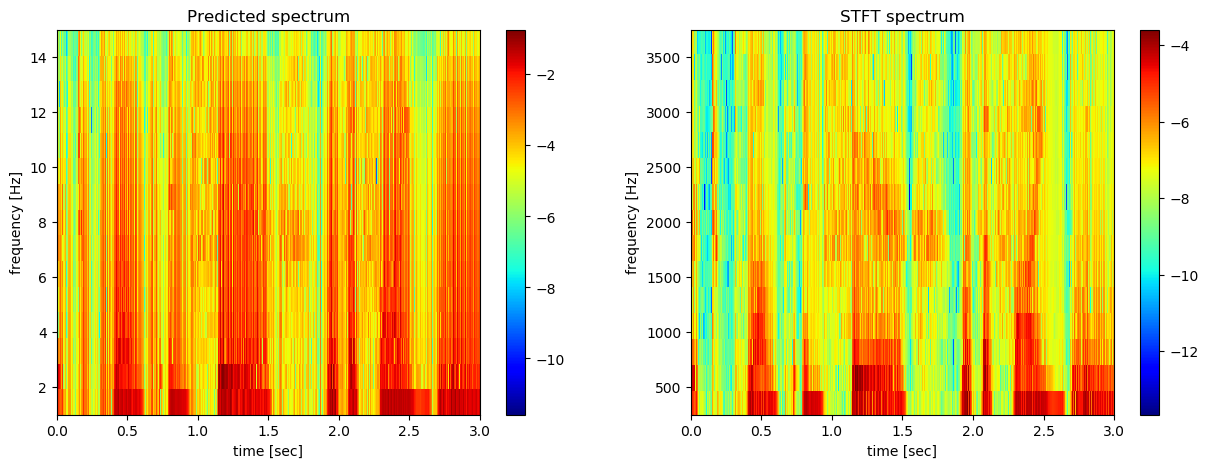

In [10]:
# convert μθa 1d array
#μ_x_pred = expand((hcat(μ_x...),dims=1))

# convert s_x to a 2d array
if length(size(μ_s)) != 2
    μ_s = hcat(μ_s...)
end

# calculate magnitude spectrum
mag_μ_s = log10.((μ_s[1:length(freq),:].^2 + μ_s[length(freq)+1:end,:].^2))


# create figure with subplots
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
cmp = ax[1].imshow(mag_μ_s,
                   aspect="auto",
                   cmap="jet",
                   origin="lower",
                   extent=[minimum(t), maximum(t), 1, length(freq)])
fig.colorbar(cmp, ax=ax[1])

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, 2*length(freq)+1, 0, fs=fs_desired), fs_desired, ax=ax[2], colorbar=true)

# change visuals
ax[1].set_xlim(minimum(t), maximum(t)), ax[2].set_ylim(minimum(freq), maximum(freq)), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("frequency [Hz]"), ax[1].set_title("Predicted spectrum"), ax[2].set_title("STFT spectrum")
#cmp.set_clim(-3, -16)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQBAB9e99dwSvvOCzr0Y0K69b3FzvS43ALwLE4A9PwrqPS2aMj5i1Wk+OTqBPi5vcz4LIms+nr0SPofdnDzp1/68xy7UvHWp2705qEe+OFsmvn1Ulr2+b0K9u5EqvdpOhboVHD09fGo4PZfZhjygR428jt9TvbVHgr09r6q9xGHvvQanEL462+y9/NKlvUKogr0qtS+97VHvPH8A6z2nDy0+a0BQPq6/ej4dZoE+mVZ4Po8LJj7Vhh49mJHevFk927zBps69SxBNvhQPQb5tV8K93PdJvZUucb1yrs68ZAMhPdtScj2aZBE9V/o9PJe7jrzOwEW9zzyavaBCy720ZAm+ZtIFvoLa0L09q5u9T9MvvS96HT2vDQk+sAJBPn7zYj4TpYY+TJaNPlDAWT7IHZU9FNb8O8hZEbpm2pm9CmlSvmQjYr40YQa+t8iqvWqMyb1nt469zvPMPBSUrT2LmHk9BNKcPKKDTzzImM48Dx+PvBGavr3cYAW+QgbqvT2b0b1XLdK9wKGpvTpBrLutIrk9gUgiPuJjQD5tzGc+rCCJPoBiej6M0QI+iiNXPDReaTvA/ae8CwgWvsZwdb40wze+9pzcvd9B4b128N29QiUTvd/CBD2nH1M9rgsTPaeHVTww2mA7ortsPB63j7wqI7i9aorUvauXT70Jfd+8Q03xvH55Qz2hYzA+6nhpPsFdaT7KQGw+iXodPgstij0WuUA9UY0TvBSXIL7Hmla+E3sUvik//r2/jSC+DXLxvZ0udrxwSEE9uziEPXhcpz1qNIQ96sMqPfDiNz1F2o08PQSkvZe8Dr6xq9G9i5G5vQeLEb66tAW+e2QPvRwSAD2VrzI99k6vPccDFT77MTE+6tkZPlnF+z0vzsU984ODPelYqTwCeOG8tawmvfsbMr1aWqe9bVbrvStAqr3DyGi9vkmPvcRBhr0KA0u8090dPNbah7zXSgu9XqLQvJMyhLxwj4W80YAsvGh7QDzEEYM9CVYBPr8/Lj7yH0k+M4VxPisqVD5Ul4A9OtEtvOo6ujzopSm9teZUviMqXb6iR8W9f9mxvV7aHL5BZra9Fno+PVGxvD3tBYw9iPCwPTYt+z31OfQ9E4ybPd+lXDxzWhi9DE+AvQTjkL05d+C9QrwKvj49170PI0u9Y0AqvUAdGL0/LQu6J9EtPW4rJz33pcY8xK/FPPeazDzyzqo7Q5/ovEA2EL1Gy8a8in2jvEWD4LwGENO8mgaZvLS0Crt35rM7HrrfOgpbo7sOe5E7Gf/8O2iK2bsS7cC89xiYvBVs0ruoFWi8m8cGvHOuPjwCvr481m6zPHGR+jxvWh09Wl8xPfS6Dz3U+r88ZLyAPA62Rzw+xKU6eNW/vAFEB71i1wG9ti0fvUnDWL2fBzm9FC0QvagbEL1FaAu9xoirvI7zZLzvW1O8M/qju4tkkjuTdxw8Ki2hPAh1HT1R7jA9qvc3Pbfsdj3ryI49OXF0PayLPD0K3AI9MMuvPEC6OLvDNfK832FyvQJ8nr0HUae9xUynvTRgvb0fR7S9wB99vYjmOb1wcha93W2kvIXwkbk1PD88fRHGPGOfAj2SwCM9hymCPXbZuj1dEts94cn7PZaLAT6YF9A9Iw13PcnyNT0wD1274IOWvRPi2r2xGdW9EBIBvksvIb4yNQi+rKS1vetRmr0BGIy98IPjvIWSMDySMbI8DUAAPQPgVz3b35E95U2ePbr8vD0oavY9jrsVPujFIT6SK+k9YLcMPW/EpzyOTA89TmUXvQlVB74QmM69mOhBvW6w0b1hnAq+EJ1ovQLrTTtQ1te8YhFWvLH0XT2muJA9EDIYPUGeGj3+3lc9jiCtPBvftLzV+c6843HavPE1X72BCoq9AMlzvZ3eXL2dlEa937wVvdR8przf7A+8VwspvJZvB7yhbxE4qVgtPFAE+zq/mfm7e74YO4EoszucLvu7jI/nuyQnkjtB+Zi7uHhcvO9ZJ7xtJ+O7DWjlu8ncgbtHNgk7KTV5O/VerzsV8M47xxwLPNcnuTw6ask8xCxxPF9zNTyu+Kg8+TmWPDL7IDwa8GY8EDl9PHm/mDuiTo66VoYSut4TsbvDUta79YXhu7jWyrs4Z8+7yIrPu/0blLqB9xq7AktYOgaDkTsavj87fm0EPF3Tcjx+rvQ7UzMUPL88nTwduFI8W2g/O8vRJTznb5g8eVgrPJamoDtwmIg7pSiNul4WuTsRHS88Sa3Xu3nW/7v1GwU8TOrSO7qLyrukUoo69dVPO5hFIzcqgrw78UVyO0NMbrk2MYc7E/QpPMo3rDvOny06Ii0QPLoXlDurnlg8x4/iO1/7NbkfJqQ8JeAjPJIftTs+YIk8fXbxOn7mxbjL0no8bIPqO1ZzTbwTn5y7LMkYupCtLrwZHBO7CvmKOcMtBryvGMk7SKueu3YYpbw65Cg8YQ2kPACnTbzM7dy8SCQDPN79vTwiN6i8cS6HvORYyzyBu2m8yNWzvOqJ1TyE4Bm7ZwQkvRG92DrCDFE8n1PKvKJU5LxgjoK7pm8DvBMEkLyGdLq7fymbvC2IKrx4yGQ893BIvPbDBr1j+yw8ArTaO6Gay7zyVhO8i9dpO6BdA7zCdIe8F/V5u0Lonzq4VJS8sDF5vKluorvly627c+iPvHQxhbyqJb27mvMhvBN8ArztXLa7wPAJu7Y38LpsjDy7x4ZBu/VTVrhxrPo6JlCdu7cPabsLlqG6UGGtuo0JQLv5ld+7SgeFuwYTkbtDqUK6tByqOVNtcrnvad+5FPxtOwpZg7ls1IW7wCYNuw1BobvTbfa7hMz7u7INz7vljve70kw6vNosB7xij667fGLbuhapVLuj1Da50vDNO0RxvTtDUBI7wgJpO0jYoTtQR+c6hVakOj1uqzp2LSq6q8AXOEQYQ7ofW7O6Z7HUuiwl5LqJfF06rEXFubuDjrvehJS7Kw+6u/Ofy7twMM67rOa5u+Qa+LpN6+W4qQFDO0A6Gzoo2wa4azaOO0kppjsV0Zs6MgGNuqrnTjuC+V07vTzruqMAXrp53187Fq5YO/i9mbkV9QW5kTJhO7gnaDuhfaE7Rte7O4JE9zvSAcQ7chLkO8VBtzucwo47tjWtO5gzQDuZH3E6yflmO034YTtcJts7RtG7O5CIfDtQ9pg78xGVOySSejuRC1c7G+apOzHN6zv6t3E7ZVwvO6fksDtv2Iw7ONLDOxUTITwd8gM8j6SuO7VwxTuYXcM7f9qYOhBgbDvnEPs1iYqDuwksrbsIkaK7wV5Vu2mOk7sRyAK6LFYVOz6UBTrZ9Am4Go6YOm479jm1xUu7F2aku2KQ1btoLfi7m8L1u91uKrwYXki8I1lBvPTzL7xD3Vq8lNQtvACRGLzw4zi8Uec8vJfSO7zA+j682IxqvM3EWbxg83O8ekh0vMDobLxNNF28GpRwvNgRY7xNhQS8fb44vHkXM7yVvxi8joMPvESTELyVYVi8rxNcvA4zZ7ytGUG8FcYzvHmGN7ym2TO8wQoovKDSNrxctEu8J+xFvGPzCrzKCBq8q+ExvEG2CbyRoNK7MA72uyCTortPpnu7RLD2u74Q37va/4W76CtYu26rVru8q4K7OPKau/I8N7qPAee64ClzurKOszmECk84NfDuOrUSQDrinhs5L0AVO+6f77rMY2u7ATunOXInZLmB/0s62PwgOfNScjuqBkM7KHANOxfTqTuG/cc78LurOyswHDwXOOM7LgnbOwpWxTsELLA7G6jgO87dkzvbIvY78Je1O3iDhjvJppM7t/r8O09r6jvDArY7CJANPG47DTwXx6I7F8jVOxyXCjzxgiA85pklPOLZGzzF1w48TqEkPNsgRDyzpw48a/raO1LkDzxfA

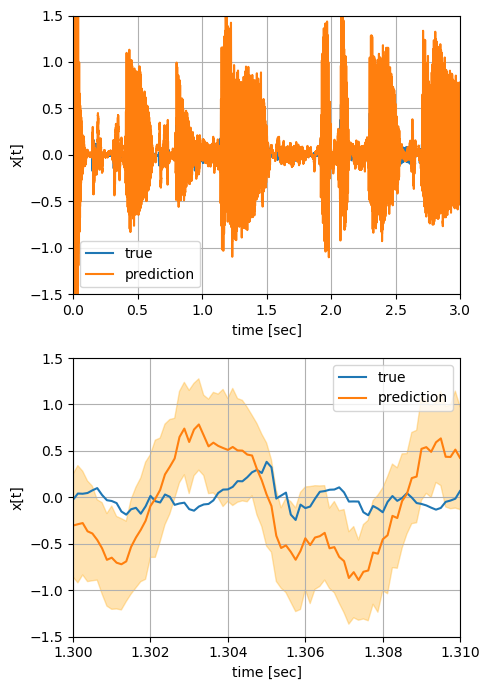

In [11]:
# create figure with subplots
fig, ax = plt.subplots(nrows=2, figsize=(5,7))

μ_x_pred_select = [μ_x[k][1] for k = 1:length(μ_x)]
var_x_pred_select = [Σ_x[k][1,1] for k = 1:length(μ_x)]

# plot actual, noisy and marginal of frequency component
ax[1].plot(t, x_time, label="true"), ax[1].plot(t[buffer_size:length(μ_x_pred_select)+buffer_size-1], μ_x_pred_select, label="prediction")#, ax[1].plot(t[1:length(μ_x_pred_norm)], μ_x_pred_norm, label="normalized prediction")
ax[2].plot(t, x_time, label="true"), ax[2].plot(t[buffer_size:length(μ_x_pred_select)+buffer_size-1], μ_x_pred_select, label="prediction")#, ax[2].plot(t[1:length(μ_x_pred_norm)], μ_x_pred_norm, label="normalized prediction")
ax[2].fill_between(t[buffer_size:length(μ_x_pred_select)+buffer_size-1], μ_x_pred_select .- sqrt.(var_x_pred_select), μ_x_pred_select .+ sqrt.(var_x_pred_select), alpha=0.3, color="orange")

# change vizualization
ax[1].grid(), ax[1].set_xlim(0,3), ax[1].set_ylim(-1.5, 1.5), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("x[t]"), ax[1].legend()
ax[2].grid(), ax[2].set_xlim(1.3,1.31), ax[2].set_ylim(-1.5, 1.5), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("x[t]"), ax[2].legend()
plt.tight_layout()

#plt.savefig("figures/all_AR02.png", dpi=500)

# create audioplayers
audioplayers(x_time, x_time_clean, μ_x_pred_select, fs=fs_desired)
;

## Performance metrics

In [12]:
MSE = 1/length(μ_x_pred_select) * sum(abs.(μ_x_pred_select - x_time[buffer_size:length(μ_x_pred_select)+buffer_size-1]).^2)

0.1534963249884619

In [13]:
MAE = 1/length(μ_x_pred_select) * sum(abs.(μ_x_pred_select - x_time[buffer_size:length(μ_x_pred_select)+buffer_size-1]))

0.2246539246539834

In [14]:
using Distributions;
logBME = Float64[]
# initialize buffer
buf = BufferData(x_time, t, buffer_size)
for k = 1:length(μ_x)
    try 
        push!(logBME, logpdf(Distributions.Normal(μ_x_pred_select[k], sqrt(var_x_pred_select[k])), buf.buffer_s[1]))
    catch
    end
    step!(buf, step_size)
end
print("nr: "* string(length(logBME))* "       mean:"* string(mean(logBME)))

nr: 23970       mean:-0.5603371146204508